Resume Screening using NLP
Required Components:
1.) N no. of Resumes. 
2.) A CSV file.
3.) spaCy.

In [1]:
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
from spacy.matcher import PhraseMatcher

In [2]:
nlp = en_core_web_sm.load()
nlp

Create a folder which holds all Resumes to be compared

In [3]:
fname = 'C:/Users/Jeyamaruthi Cr1mzie/Desktop/For Project'  #give ur path where you are storing your resume
onlyfiles = [os.path.join(fname, f) for f in os.listdir(fname) if os.path.isfile(os.path.join(fname, f))]
onlyfiles

['C:/Users/Jeyamaruthi Cr1mzie/Desktop/For Project\\Anuj_Resume.pdf',
 'C:/Users/Jeyamaruthi Cr1mzie/Desktop/For Project\\Jeyamaruthi_Resume.pdf']

Method for extracting the PDF into text

In [7]:
def extractpdf(file):
    Reader = PyPDF2.PdfFileReader(open(file,'rb'))
    NoOfPage = Reader.getNumPages()
    count = 0
    text = []
    while count < NoOfPage:    
        Pages = Reader.getPage(count)
        count +=1
        t = Pages.extractText()
        #print (t)
        text.append(t)
    return text

Method for creating the model, matching the keywords

In [13]:
def model(file):
    text = extractpdf(file)
    text = str(text)
    text = text.replace("\\n","")
    text.lower()
    keyword_dict = pd.read_csv('Keywords.csv')
    keyword_dict
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    Python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    Front_words = [nlp(text) for text in keyword_dict['Front End Developer'].dropna(axis = 0)]
    DA_words = [nlp(text) for text in keyword_dict['Data Analysis'].dropna(axis = 0)]
    matcher = PhraseMatcher(nlp.vocab)

    # matching the Resume & CSV file
    matcher.add('ML', None, *ML_words)
    matcher.add('Python',None, *Python_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('FW', None, *Front_words)
    matcher.add('DA', None, *DA_words)
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  
        span = doc[start : end]  
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List']) #dataframe which holds all data                   (Step 1)
                                                                   #i.e. "Subject, Keyword & count in single column"
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword']) # seperated subject  from
                                                                                                   # step 1          (Step 2)
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count']) # Segregating the count from S2
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) #forming a new dataframe with 3 columns
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))  # Seperating the bracket from Count 
    base = os.path.basename(file)   #Filename with extension
    filename = os.path.splitext(base)[0]  #only the file name

    name = filename.split('_') #Name of the file (The uploaded file should be in the form Name_Resume (eg:Jeyamaruthi_Resume))
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name']) 

    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

In [14]:
final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = model(file)
    final_database = final_database.append(dat)
    i +=1
    print(final_database)

  Candidate Name Subject             Keyword Count
0           anuj      ML  Linear Regression      1
1           anuj      DA                SQL      3
2           anuj      DA             Pandas      1
3           anuj  Python             Pandas      1
4           anuj  Python         matplotlib      1
5           anuj  Python            sklearn      1
6           anuj      DA              Excel      2
   Candidate Name Subject             Keyword Count
0            anuj      ML  Linear Regression      1
1            anuj      DA                SQL      3
2            anuj      DA             Pandas      1
3            anuj  Python             Pandas      1
4            anuj  Python         matplotlib      1
5            anuj  Python            sklearn      1
6            anuj      DA              Excel      2
0     jeyamaruthi      FW                PHP      1
1     jeyamaruthi      FW               HTML      1
2     jeyamaruthi      FW                CSS      1
3     jeyamaruthi   

Plotting the rest

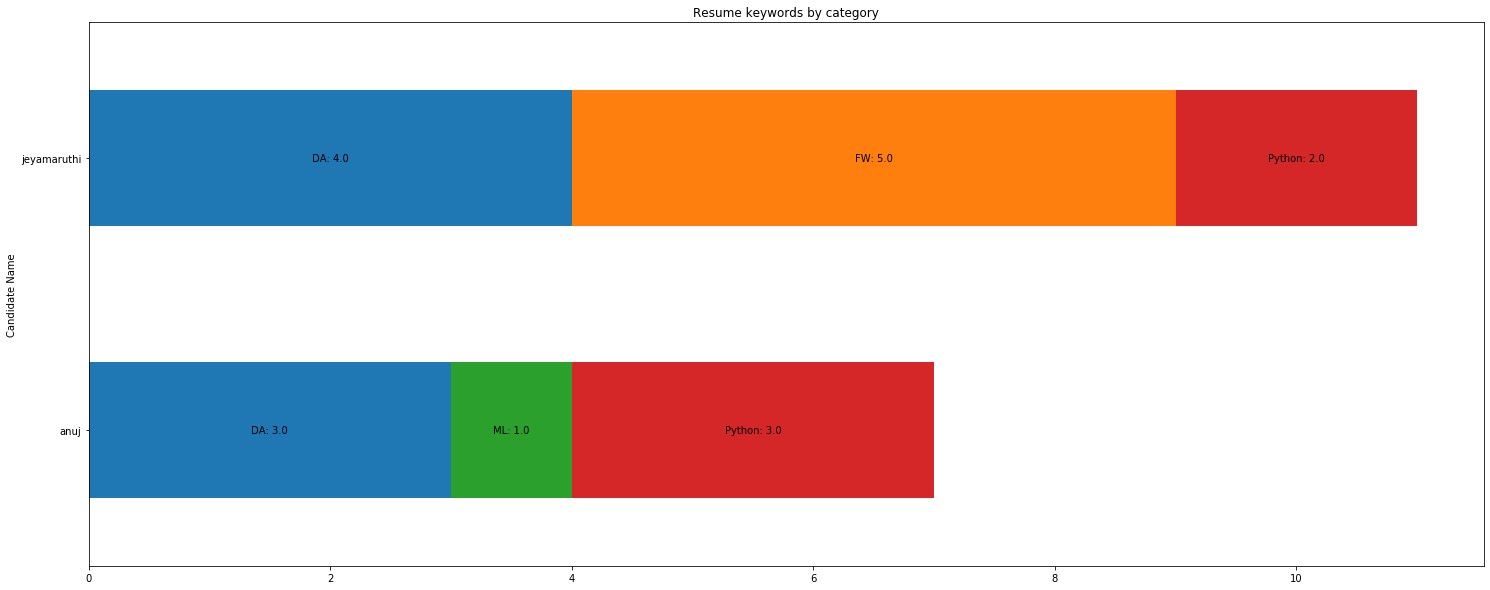

In [15]:
#Fills the new database into format as S.No, Candidate Name, Subjects(which holds the count)
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True) 
final_database2.fillna(0,inplace=True) # Replace NAN with 0
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']

#execute the below line if you want to see the candidate profile in a csv format
# soft_copy=new_data.to_csv('jeyamaruthi.csv')

# Lets start plotting the graph with collected data
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,10), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x() 
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

For better understand for people reviewing my code

In [21]:
#for user friendly: For better understanding
temp_variable = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
temp_variable.reset_index(inplace = True) 
temp_variable.fillna(0,inplace=True) 
temp_variable

Subject,Candidate Name,DA,FW,ML,Python
0,anuj,3.0,0.0,1.0,3.0
1,jeyamaruthi,4.0,5.0,0.0,2.0
